In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import ROOT
import root_numpy

import matplotlib.pyplot as plt

PATH = "/root/minibias2.root"

import warnings
warnings.filterwarnings('ignore')

import json

Welcome to ROOTaaS 6.06/02


In [2]:
import os.path as osp

In [4]:
with open("./branches_photon.config") as f:
    features = json.load(f)

In [5]:
features['per_event']

{u'PF': {u'batch': 1536,
  u'branches': [u'recoPFCandidates_particleFlow__RECO.obj.pt_',
   u'recoPFCandidates_particleFlow__RECO.obj.eta_',
   u'recoPFCandidates_particleFlow__RECO.obj.phi_'],
  u'read_each': 8},
 u'calo': {u'batch': 64,
  u'branches': [u'recoCaloJets_ak5CaloJets__RECO.obj.pt_',
   u'recoCaloJets_ak5CaloJets__RECO.obj.eta_',
   u'recoCaloJets_ak5CaloJets__RECO.obj.phi_',
   u'recoCaloJets_ak5CaloJets__RECO.obj.mass_',
   u'recoCaloJets_ak5CaloJets__RECO.obj.vertex_.fCoordinates.fX',
   u'recoCaloJets_ak5CaloJets__RECO.obj.vertex_.fCoordinates.fY',
   u'recoCaloJets_ak5CaloJets__RECO.obj.vertex_.fCoordinates.fZ'],
  u'read_each': 1},
 u'muons': {u'batch': 24,
  u'branches': [u'recoMuons_muons__RECO.obj.pt_',
   u'recoMuons_muons__RECO.obj.eta_',
   u'recoMuons_muons__RECO.obj.phi_',
   u'recoMuons_muons__RECO.obj.mass_',
   u'recoMuons_muons__RECO.obj.vertex_.fCoordinates.fX',
   u'recoMuons_muons__RECO.obj.vertex_.fCoordinates.fY',
   u'recoMuons_muons__RECO.obj.verte

In [6]:
features['per_lumisection']

[u'EventAuxiliary.id_.run_',
 u'EventAuxiliary.id_.luminosityBlock_',
 u'EventAuxiliary.time_.timeHigh_',
 u'EventAuxiliary.time_.timeLow_',
 u'LumiScalerss_scalersRawToDigi__RECO.obj.instantLumi_']

In [119]:
def get_index(leaves, indxes):
    """
    Produces names of branches with indexes in them.
    """
    return [ leaf + "[%d]" % index for leaf in leaves for index in indxes ]

def split_by_events(data_root, leaves, batch_size, test_leaf = 0):
    """
    Turns data from root numpy into matrix <N events> by <number of features>.
    Returns if another batch is needed by testing test_leaf (usually pt - momentum) against exact float zero.
    If any particles has test_leaf equal to exact zeros, they are just doesn't exist in original root file, so
    needed to be truncated.
    Otherwise, event might be read incompletely, i.e. number of particles > batch_size.
    """
    events = list()

    for event_i in xrange(data_root.shape[0]):
        event = data_root[event_i]
        d = np.array([ event[i] for i in xrange(len(leaves) * batch_size) ]).reshape(len(leaves), -1).T
        
        event_idx = d[:, test_leaf] > 0.0
        
        ### other features must be exact zero also
        assert np.all(d[np.logical_not(event_idx), :] == 0.0)
        
        events.append(d[event_idx, :])

    need_another_batch = np.any([
        event.shape[0] == batch_size for event in events
    ])
    
    return need_another_batch, events
    
    
def read_batch(path, treename, leaves, batch_size, each = 1, test_leaf = 0):
    event_batches = None
    need_another_batch = True
    
    batch_offset = 0

    while need_another_batch:
        branches = get_index(leaves, np.arange(batch_size)[::each] + batch_offset)
        
        data_root = root_numpy.root2array(path, treename='Events', branches=branches, )

        need_another_batch, events = split_by_events(data_root, leaves, batch_size / each, test_leaf = 0)
        
        batch_offset += batch_size
        
        if event_batches is None:
            event_batches = [ [event] for event in events ]
        else:
            assert len(event_batches) == len(events)
            event_batches = [
                batches + [batch] for batches, batch in zip(event_batches, events)
            ]
    

    return [ np.vstack(event) for event in event_batches ]

def read_lumidata(path, lumifeatures):
    names = [ f.split('.')[-1] for f in lumifeatures ]

    lumidata = root_numpy.root2array(path, treename='Events', branches=lumifeatures)
    lumi = np.zeros(shape=(lumidata.shape[0], len(lumifeatures)))

    for i in xrange(lumidata.shape[0]):
        lumi[i, :] = np.array([ lumidata[i][j] for j in range(len(lumifeatures)) ])
    
    lumi = pd.DataFrame(lumi, columns=names)
    lumi['luminosityBlock_'] = lumi['luminosityBlock_'].astype('int64')
    lumi['run_'] = lumi['run_'].astype('int64')
    
    return lumi
    
def read_lumisection(path, features):
    lumi = read_lumidata(path, features['per_lumisection'])
    
    events = dict()
    for category in features['per_event']:
        fs = features['per_event'][category]['branches']
        read_each = features['per_event'][category]['read_each']
        batch_size = features['per_event'][category]['batch']
        
        assert batch_size > read_each
        assert batch_size % read_each == 0
        
        events[category] = read_batch(path, treename='Events', leaves=fs,
                                      batch_size=batch_size, each=read_each, test_leaf=0)
    
    return lumi, events

In [139]:
def get_percentile_paticles(event, n = 3, test_feature = 0):
    sort_idx = np.argsort(event[:, test_feature])
    event = event[sort_idx, :]

    if event.shape[0] >= n:
        ### preserving the last event with maximal momentum (test_feature)
        fetch_idx = [i * (event.shape[0] / n) for i in xrange(n-1)] + [event.shape[0] - 1]
        return event[fetch_idx, :]
    else:
        missing = n - event.shape[0]
        return np.vstack([
            np.zeros(shape=(missing, event.shape[1])),
            event
        ])
    
def integrate(event):
    try:
        pt = event[:, 0]
        eta = event[:, 1]
        phi = event[:, 2]
    
        theta = 2.0 * np.arctan(np.exp(-eta))
    
        px = np.sum(pt * np.cos(theta))
        py = np.sum(pt * np.sin(theta) * np.cos(phi))
        pz = np.sum(pt * np.sin(theta) * np.sin(phi))
        return np.array([px, py, pz])
    except:
        return np.zeros(shape=3)
    
    
def process_channel(channel, branches, prefix = "", n = 3, test_feature=0):
    selected = np.array([
        get_percentile_paticles(event, n = n, test_feature = test_feature).flatten()
        for event in channel
    ]).astype('float32')
    
    total_momentum = np.array([
        integrate(event[:3, :])
        for event in channel
    ]).astype('float32')
    
    branch_names = [ prefix + '_' + branch.split(".")[-1] for branch in branches ]
    
    feature_names = [
        "%s_q%d" % (branch, q + 1) for q in range(n) for branch in branch_names
    ] + [
        prefix + '_' + "P%s" % component for component in list("xyz")
    ] 
    
    df = pd.DataFrame(np.hstack([selected, total_momentum]), columns = feature_names)
    return df

In [158]:
def process(data, features, lumidata, n = 3, test_feature = 0):
    channels = list()
    names = list(lumidata.columns)

    for category in data:
        d = process_channel(data[category], features[category]['branches'],
                            prefix = category, n = n, test_feature = test_feature)
        
        names += list(d.columns)
        
        channels.append(d)
    
    df = pd.concat([lumidata] + channels, axis=1, names = names, ignore_index=True)
    df.columns = names
    return df

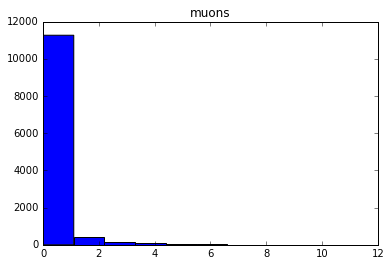

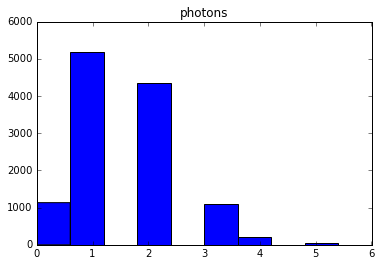

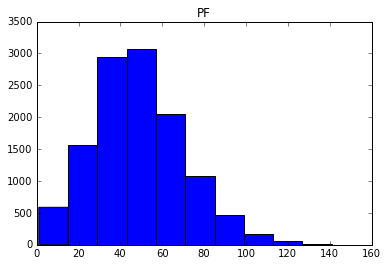

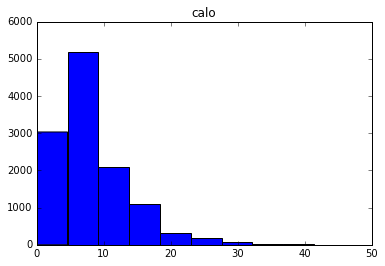

In [162]:
for cat in events:
    plt.hist([ event.shape[0] for event in events[cat] ])
    plt.title(cat)
    plt.show()

In [159]:
c = process(events, features['per_event'], lumidata)

In [160]:
c.to_pickle("c.pickled")

In [161]:
c

,run_,luminosityBlock_,timeHigh_,timeLow_,instantLumi_,muons_pt__q1,muons_eta__q1,muons_phi__q1,muons_mass__q1,muons_fX_q1,...,calo_pt__q3,calo_eta__q3,calo_phi__q3,calo_mass__q3,calo_fX_q3,calo_fY_q3,calo_fZ_q3,calo_Px,calo_Py,calo_Pz
0,146644,1224,1285463010,95585,19.096954,0.000000,0.000000,0.000000,0.000000,0.000000,...,46.347794,0.376394,1.177975,6.275603,0.095045,0.013055,-4.442827,55.848282,16.159065,38.907120
1,146644,1224,1285463010,377120,19.096954,0.000000,0.000000,0.000000,0.000000,0.000000,...,51.387669,2.291085,-0.824405,12.670225,0.093539,0.012319,-2.976851,66.443405,-24.959877,14.404644
2,146644,1224,1285463010,735485,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,46.546787,-0.192384,-1.388777,6.448455,0.092027,0.024673,12.028056,-38.463974,6.724241,-33.914780
3,146644,1224,1285463010,993188,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,42.410381,-0.826786,-2.899447,6.521376,0.094940,0.012578,2.479975,-57.288063,-24.574667,-5.050786
4,146644,1224,1285463011,614948,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.376713,-0.097495,-1.976657,1.653828,0.089640,0.014461,-10.516521,-6.239570,-1.939950,-7.766619
5,146644,1224,1285463011,545676,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,34.949863,0.082293,1.151670,3.676551,0.089812,0.017895,-3.835010,-5.585491,7.096694,29.687090
6,146644,1224,1285463011,845529,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.341619,-3.082617,0.844027,0.429878,0.101291,0.020989,3.308096,-3.327605,0.203133,0.228466
7,146644,1224,1285463011,846952,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,38.243462,0.595802,-0.955439,5.103288,0.091806,0.012328,-6.555016,-1.221660,14.850039,-21.151955
8,146644,1224,1285463012,497167,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,40.053913,-3.820030,0.598588,6.644757,0.097805,0.019607,3.335063,-88.108727,-7.162678,-2.472482
9,146644,1224,1285463012,446391,19.095190,0.000000,0.000000,0.000000,0.000000,0.000000,...,40.608257,-0.393190,1.728520,6.359371,0.090439,0.023509,-4.255210,-39.123051,-5.210696,33.882893


In [120]:
%%time

lumidata, events = read_lumisection("root://eospublic.cern.ch//eos/opendata/cms/Run2010B/Photon/AOD/Apr21ReReco-v1/0000/041D347A-D271-E011-908B-0017A477003C.root", features)

CPU times: user 2min 20s, sys: 358 ms, total: 2min 21s
Wall time: 2min 28s


In [9]:
%%time

#data = read_lumisection("../../minibias2.root", features)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 16 µs


In [10]:
import cPickle

with open('minibias2.pickled', 'w') as f:
    cPickle.dump(a, f)

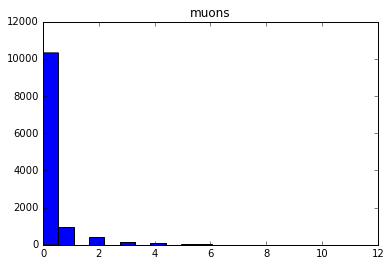

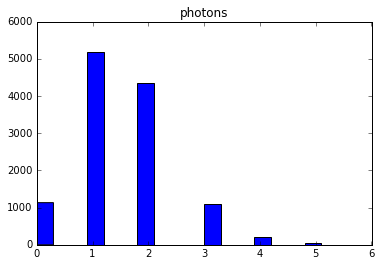

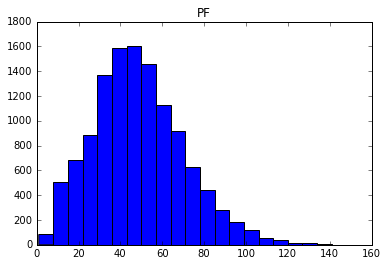

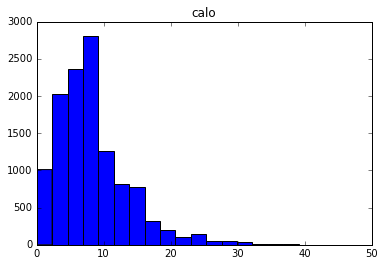

In [11]:
for category in a['events']:
    plt.hist( [ x.shape[0] for x in a['events'][category] ], bins=20)
    plt.title(category)
    plt.show()